# Proximal Policy Optimization

Adapted from https://github.com/nathanmargaglio/Proximal-Policy-Optimization

You'll get some warnings, and I'm sure there's bugs, but you should be able to run this, end to end, in less than 5 minutes on Google Colab and see reasonable results.

In [2]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.4 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym

# Advantage Actor-Critic

To start, we'll implement a basic A2C agent to test and compare to our PPO agent.

In [4]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

class Actor(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, X):
        return self.model(X)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1)
        )

    def forward(self, X):
        return self.model(X)

In [24]:
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)

adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99

episode_rewards = []

for episode_idx in range(100):
    print(f"Running episode {episode_idx}", end="\r")
    done = False
    total_reward = 0
    observation, info = env.reset()

    while not done:
        probs = actor(t(observation))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()

        next_observation, reward, done, truncated, info = env.step(action.detach().data.numpy())
        advantage = reward + (1-done)*gamma*critic(t(next_observation)) - critic(t(observation))

        total_reward += reward
        observation = next_observation

        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()

    episode_rewards.append(total_reward)

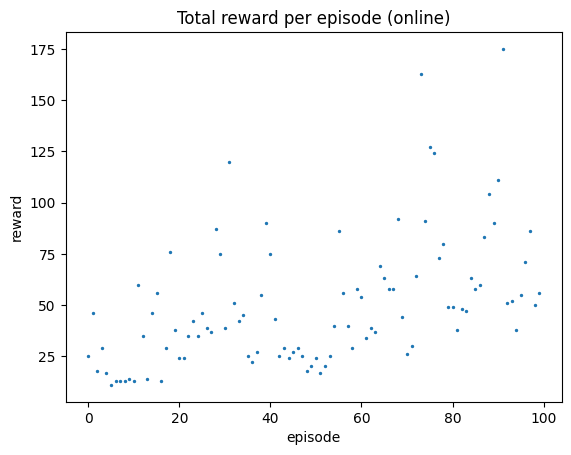

In [25]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (online)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

## PPO Agent

Here we implement the agent code for [PPO](https://arxiv.org/abs/1707.06347).

In [26]:
class Agent:
    def __init__(self, n_obs, n_actions,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-3, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=128, debug=False):
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.debug = debug

        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size

        # Build Actor and Critic models
        self.actor = Actor(self.n_obs, self.n_actions, self.hidden_size)
        self.critic = Critic(self.n_obs, self.hidden_size)

        # Create Optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.critic_lr)

    def ppo_loss(self, y_true, y_pred, advantage, old_pred, debug=False):
        # Defines the PPO loss to be used during actor optimization

        # advantage is a vector of size 1 passed in from the critic
        # This summing flattens it
        adv = torch.sum(advantage, dim=1).detach()
        if debug: print('advantage     :', adv)

        # y_true is one-hot vector denoting the action taken
        # y_pred is the output of the actor neural network
        # for the given observation
        # e.g., y_true = [0,1,0], y_pred = [0.2, 0.5, 0.3]
        # so prob = y_true * y_pred = [0, 0.5, 0]
        prob = t(y_true) * y_pred
        if debug: print('prob          :', prob)

        # old_pred is the actor's previous probabilty distribution
        # for the given observation
        # e.g., y_true = [0,1,0], old_pred = [0.2, 0.4, 0.4]
        # so prob = y_true * old_pred = [0, 0.4, 0]
        old_prob = t(y_true) * t(old_pred)
        if debug: print('old_prob      :', old_prob)

        # r is the ratio of the old probability to the new one
        # e.g., r = prob/old_prob = [0, 0.5/0.4, 0]
        r = torch.sum(prob/(old_prob + 1e-10), dim=1)
        if debug: print('r             :', r)

        # clipped is the value of r clipped between 1 +/- epsilon
        # e.g., r = 1.4, epsilon = 0.2 => clipped = 1.2
        clipped = torch.clamp(r, min=1-self.epsilon, max=1+self.epsilon)
        if debug: print('clipped       :', clipped)

        # minimum is the min of r * advantage and clipped * advantage
        minimum = torch.min(r * adv, clipped * adv)
        if debug: print('minimum       :', minimum)

        # entropy bonus (to encourage exploration)
        entropy_bonus = self.entropy_loss * (prob * torch.log(prob + 1e-10))
        entropy_bonus = torch.sum(entropy_bonus, dim=1)
        if debug: print('entropy_bonus :', entropy_bonus)

        # computes the mean over all dimensions (left with a scaler)
        result = -torch.mean(minimum + entropy_bonus)
        if debug: print('result        :', result)

        return result

    def get_action(self, observation):
        # Predict the probability destribution of the actions as a vactor
        obs = observation#.reshape(1, self.n_obs)
        # print('o', obs)
        # print('s', obs.shape)

        probs = self.actor(t(obs)).detach()
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample().detach().numpy()

        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.n_actions)
        action_vector[action] = 1

        return action, action_vector, probs.numpy()

    def train_batch(self, observations, actions, probabilities, rewards):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        acts = actions[:self.buffer_size]
        probs = probabilities[:self.buffer_size]
        rews = rewards[:self.buffer_size]

        # our 'old probs' are really just the batches probs
        old_probs = probs

        # Calculate advantages
        values = self.critic(t(obs))
        advs = t(rews) - values

        # Train the actor and critic on the batch data
        for epoch in range(self.epochs):
            # TODO: batching
            actor_loss = self.ppo_loss(acts, self.actor(t(obs)), advs, old_probs)
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            y_pred_critic = self.critic(t(obs))
            critic_loss = torch.nn.MSELoss(reduction='sum')(
                y_pred_critic, t(rews)
            )
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

    def run(self, env, episodes, verbose=False):
        episode = 0
        reward_history = []

        # reset the environment
        observation, info = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size:
                # Get the action (scalar), action vector (one-hot vector),
                # and probability distribution (vector) from the current observation
                action, action_vector, prob = self.get_action(observation)

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, truncated, info = env.step(action)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['action_vector'].append(action_vector)
                tmp_batch['probability'].append(prob)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                        tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        act = tmp_batch['action_vector'][i]
                        prob = tmp_batch['probability'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs)
                        batch['action_vector'].append(act)
                        batch['probability'].append(prob)
                        batch['reward'].append(r)

                    # reset the environment
                    observation, info = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'action_vector': [],
                        'probability': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1

            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            actions = np.array(batch['action_vector'])
            probabilities = np.array(batch['probability'])
            rewards = np.array(batch['reward'])
            rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, actions, probabilities, rewards)

            # every 10th episode, log some stuff
            if (episode % 10 == 0 or episode == episodes - 1) and verbose:
                print('Episode:', episode)
                print('Reward :', reward_data)
                print('Average:', np.mean(reward_history[-100:]))
                print('-'*10)
                print()

        self.reward_history = reward_history
        return self.reward_history

In [27]:
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

agent = Agent(n_actions=n_actions, n_obs=state_dim)

episode_rewards = agent.run(env, 100)

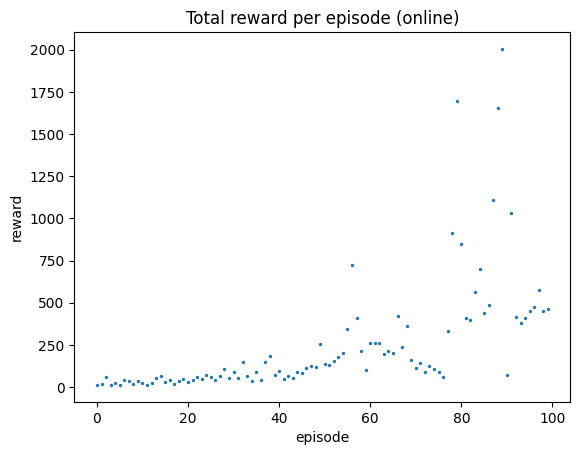

In [28]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (online)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()